In [1]:
import matplotlib.pyplot as plt

import numpy as np
import time
import itertools
import scipy.stats as stats

from ProbabilisticDiffusion import Diffusion
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import sys

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
def tweedies(data, dist, plot_grad=True, plot_density=True, plot_tweedies=True, min_val=-0.5, max_val=0.5):
    # Tweedies formula
    covariance = np.cov(data.numpy().T)
    with tf.GradientTape() as tape:
        tape.watch(data)
        prob = dist.prob(data)
        gradients = tape.gradient(prob, data)
    
    gradients = gradients.numpy()
    prob = prob.numpy()
    prob_div = prob.reshape((len(gradients), 1))
    tweedies = data.numpy() + np.clip((covariance @ (gradients / prob_div).T).T, min_val, max_val) #Clip quotient for stability
    # Plot flags
    if plot_grad:
        sum_grads = np.sum(gradients, axis=1)
        plt.scatter(data[:,0], data[:,1], c=np.clip(sum_grads, min_val, max_val), s=7 , cmap='Spectral')
        plt.title('Gradients')
        cbar = plt.colorbar()
        plt.show()
    if plot_density:
        plt.scatter(data[:,0], data[:,1], c=prob, s=7 , cmap='Spectral')
        plt.title('Density')
        cbar = plt.colorbar()
        plt.show()
    if plot_tweedies:
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((gradients/prob_div).T, min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Quotient Term')
        cbar = plt.colorbar()
        plt.show()
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((covariance @ (gradients / prob_div).T), min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Tweedies Term')
        cbar = plt.colorbar()
        plt.show()
    return tweedies


def generate_circular(n, size):
    radians = np.random.uniform(low=0.0, high=2*np.pi, size=n)
    x = size * np.cos(radians)
    y = size * np.sin(radians)
    return x, y

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


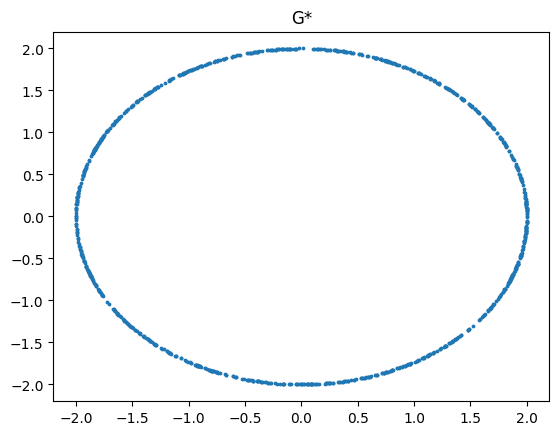

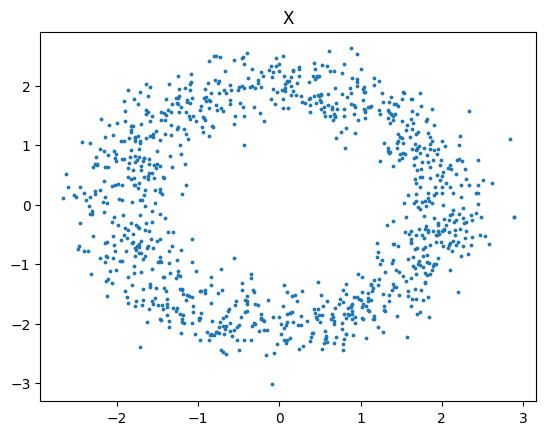

In [2]:
n=1000
x_orig, y_orig = generate_circular(n, 2)

plt.scatter(x_orig, y_orig, s=3)
plt.title('G*')
plt.show()

x = x_orig + np.random.normal(loc=0.0, scale=0.3, size=n)
y = y_orig + np.random.normal(loc=0.0, scale=0.3, size=n)

plt.scatter(x, y, s=3)
plt.title('X')
plt.show()

In [3]:
data = torch.stack([torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)],dim=1)

In [4]:
n_steps=200
model = ConditionalModel(n_steps)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
diffusion = Diffusion(data, n_steps,
                 1e-5, 1e-2, 'linear',
                 model, loss, optimizer)

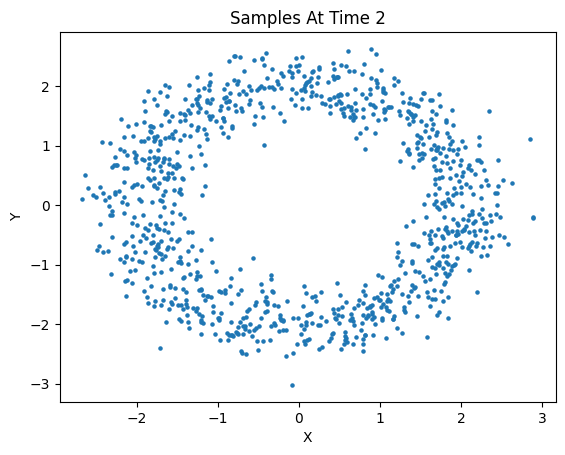

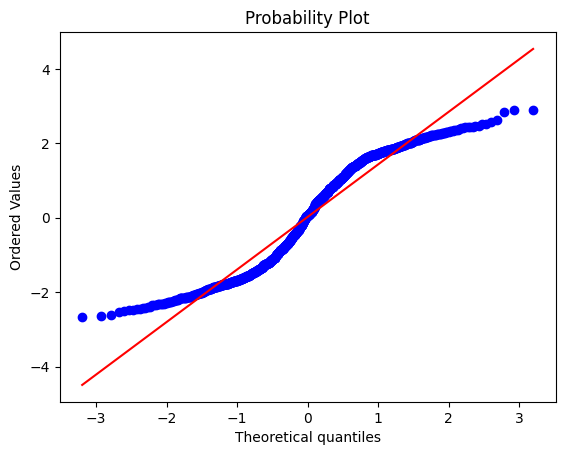

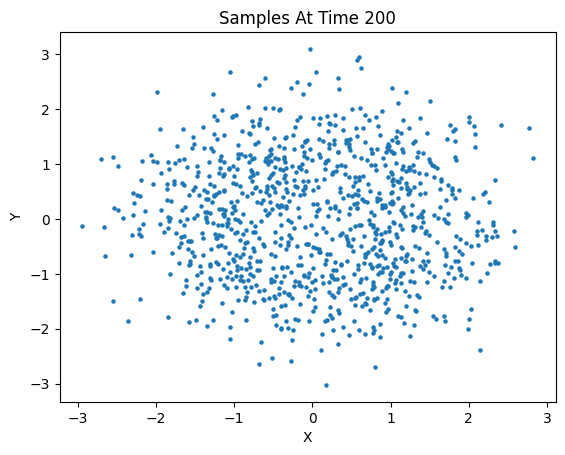

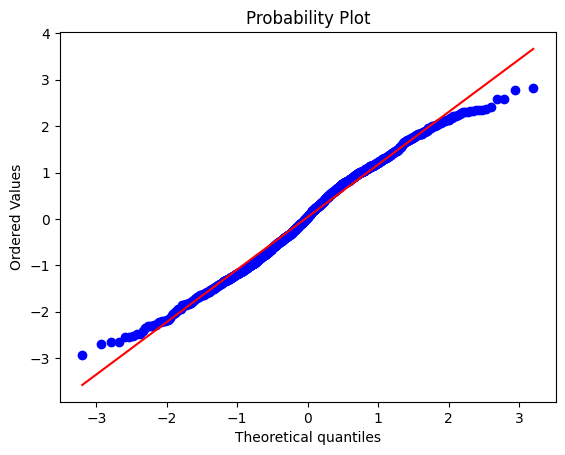

In [5]:
noised = diffusion.forward(1, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()
noised = diffusion.forward(199, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()

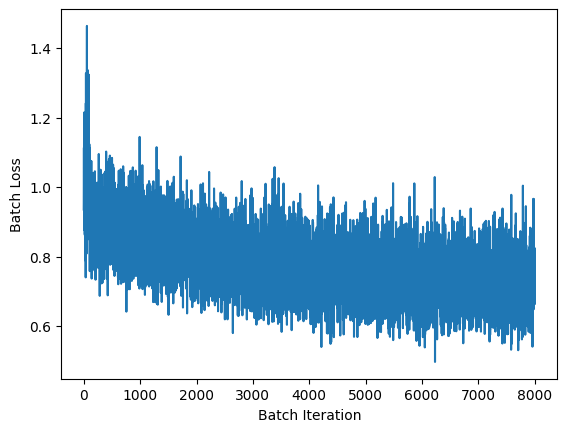

In [6]:
diffusion.train(128, 1000)

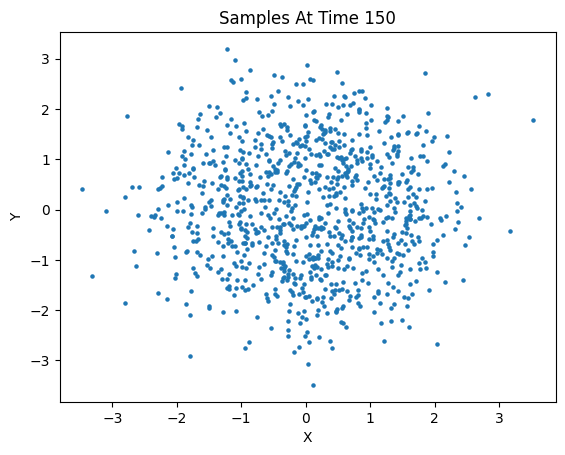

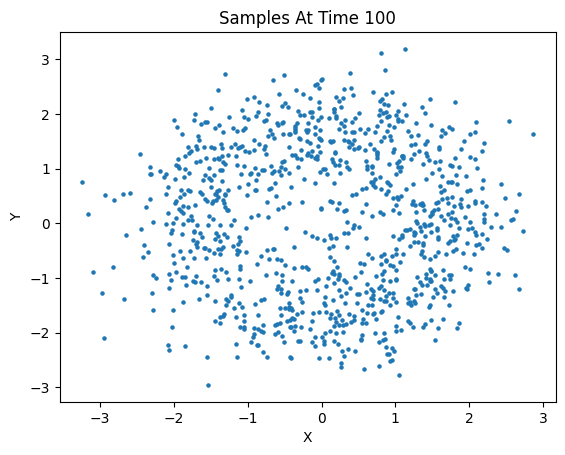

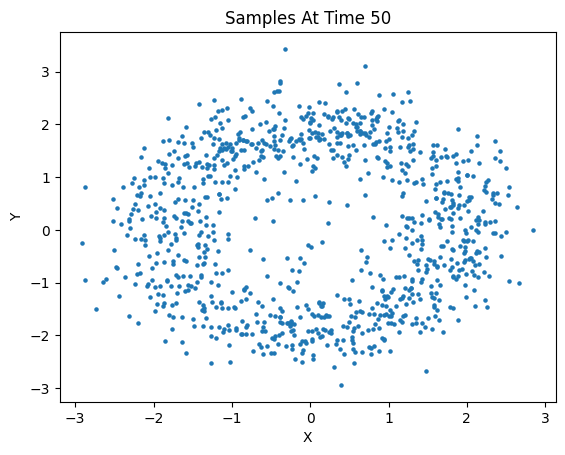

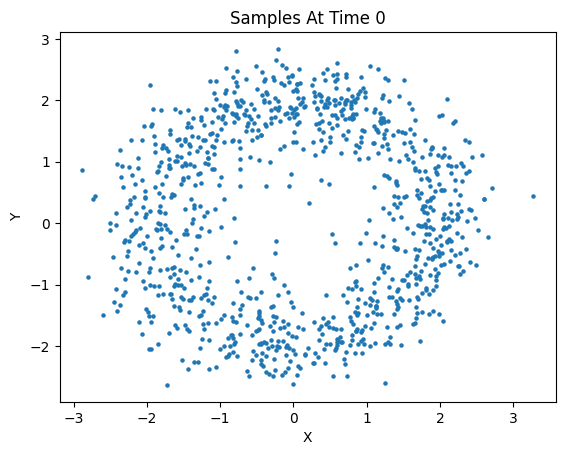

In [7]:
new_x = diffusion.sample(1000, 50, s= 5)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from helper_plot import hdr_plot_style

def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [11]:
n_steps = 100
# Create schedule
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-5, end=1e-2)
# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

tensor(0.8694, grad_fn=<MeanBackward0>)
tensor(0.9009, grad_fn=<MeanBackward0>)
tensor(0.9567, grad_fn=<MeanBackward0>)
tensor(0.7017, grad_fn=<MeanBackward0>)
tensor(0.6929, grad_fn=<MeanBackward0>)
tensor(0.6562, grad_fn=<MeanBackward0>)
tensor(0.7407, grad_fn=<MeanBackward0>)
tensor(0.9223, grad_fn=<MeanBackward0>)
tensor(0.6641, grad_fn=<MeanBackward0>)
tensor(0.7005, grad_fn=<MeanBackward0>)
tensor(0.6955, grad_fn=<MeanBackward0>)


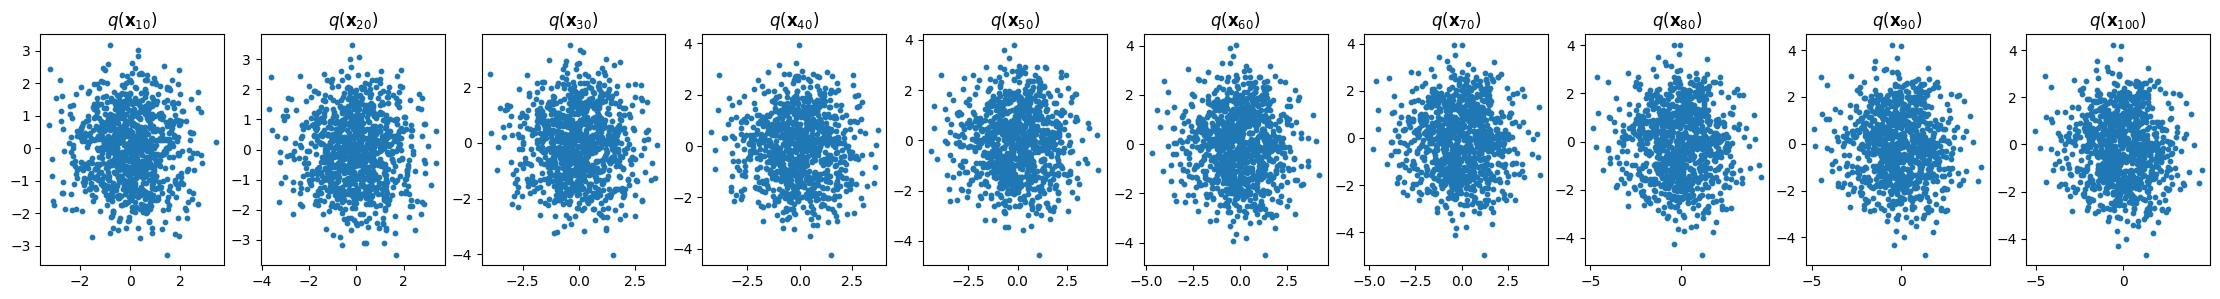

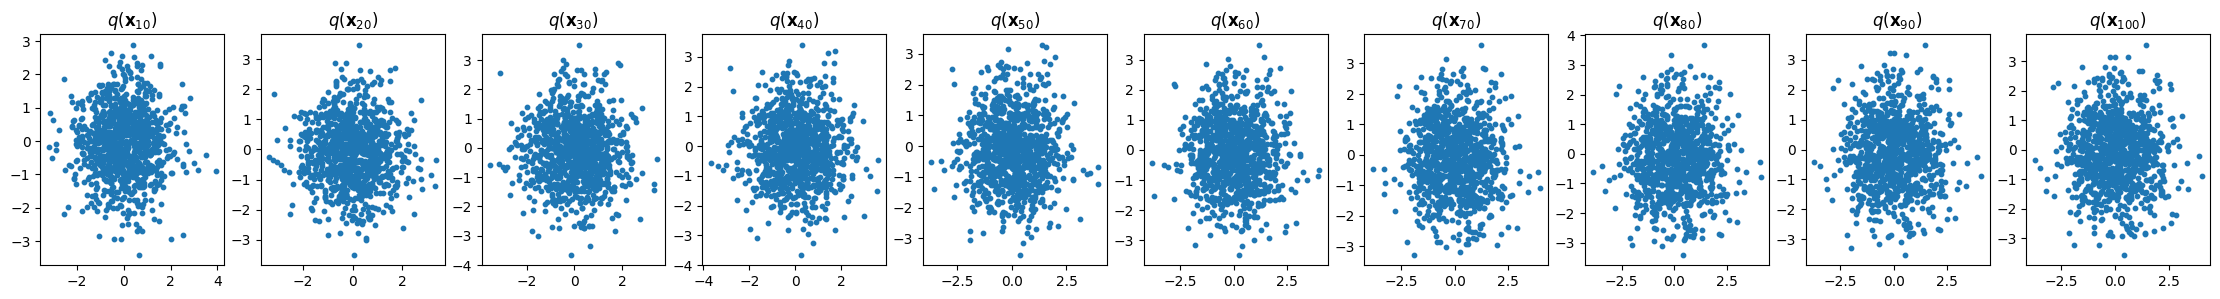

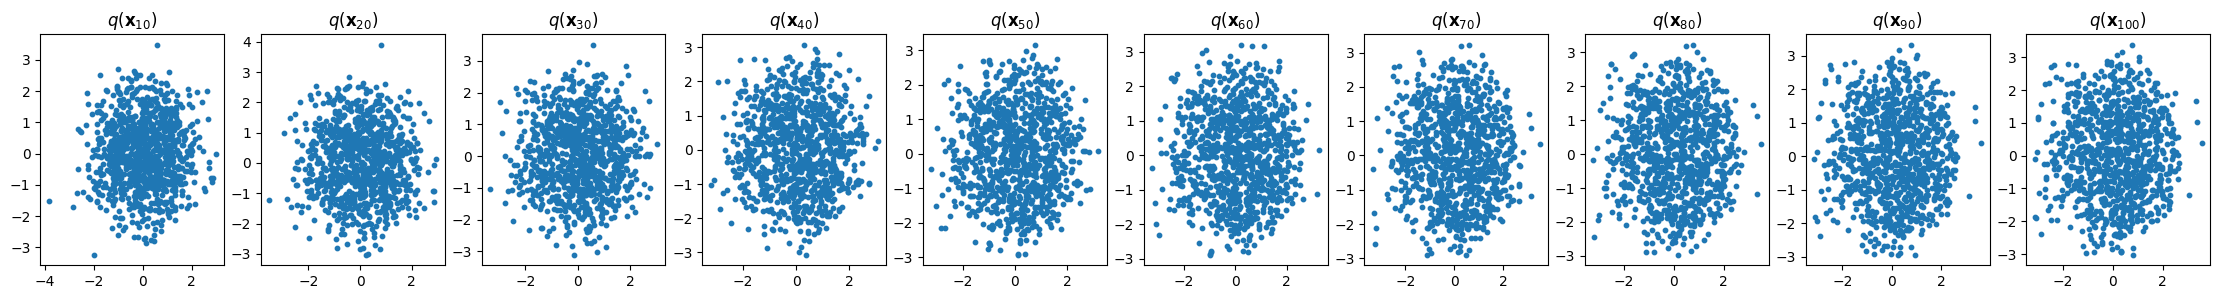

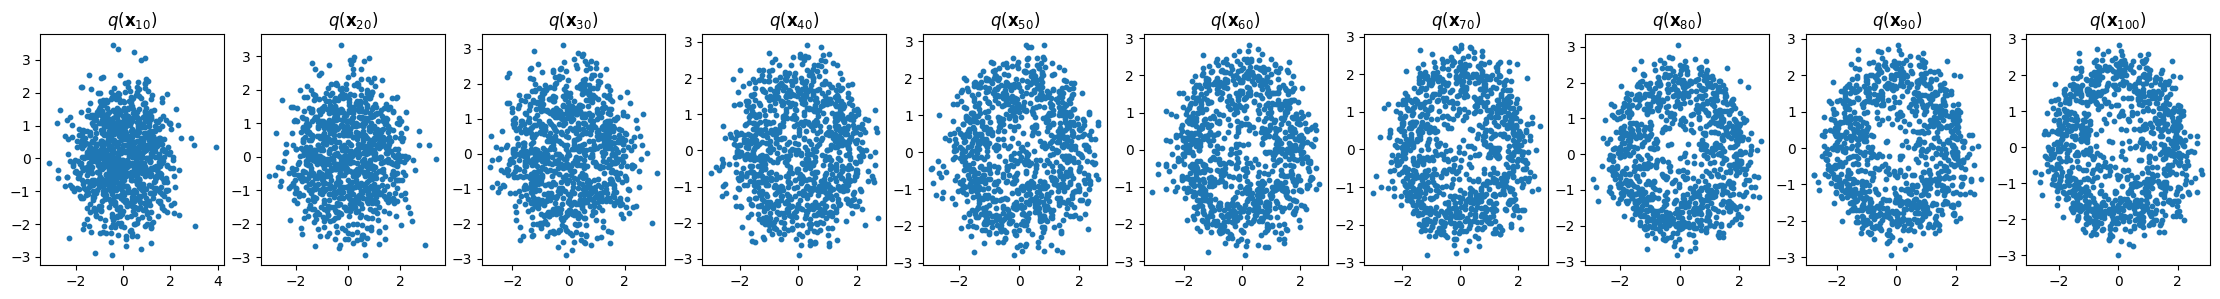

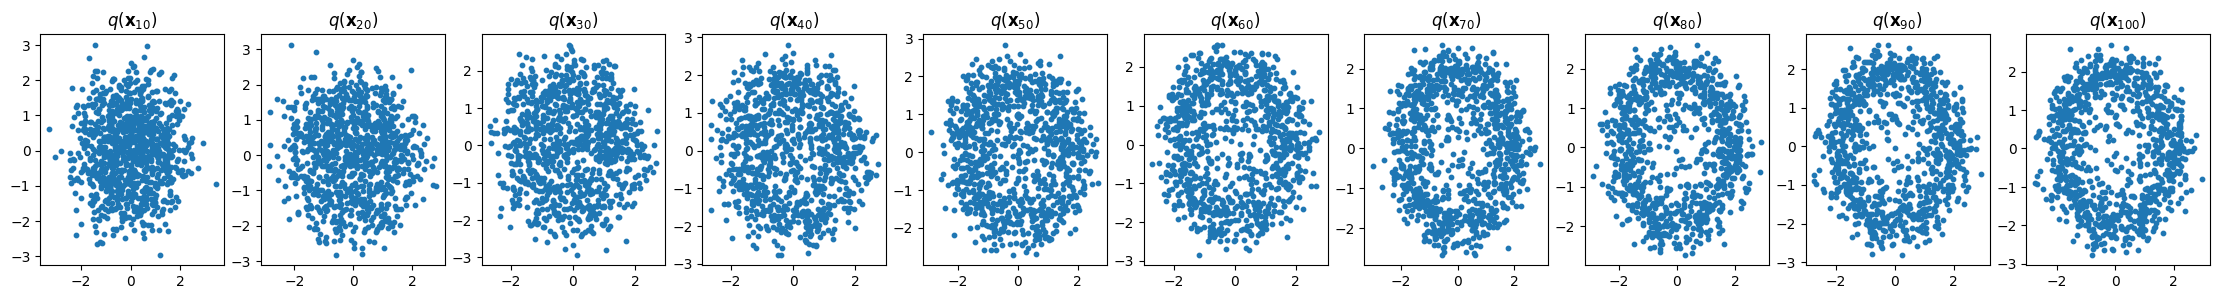

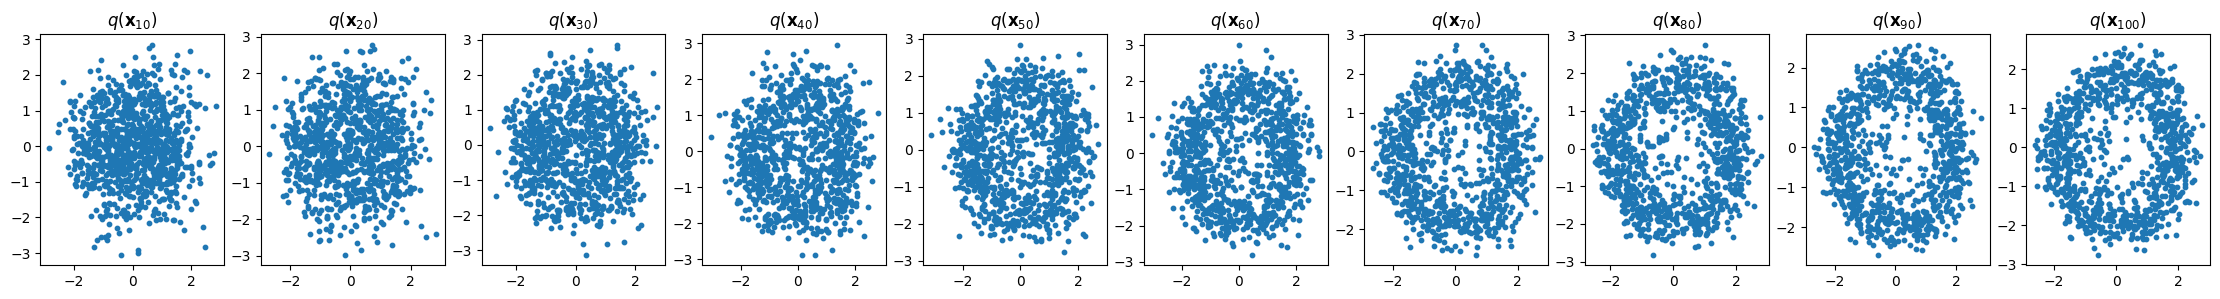

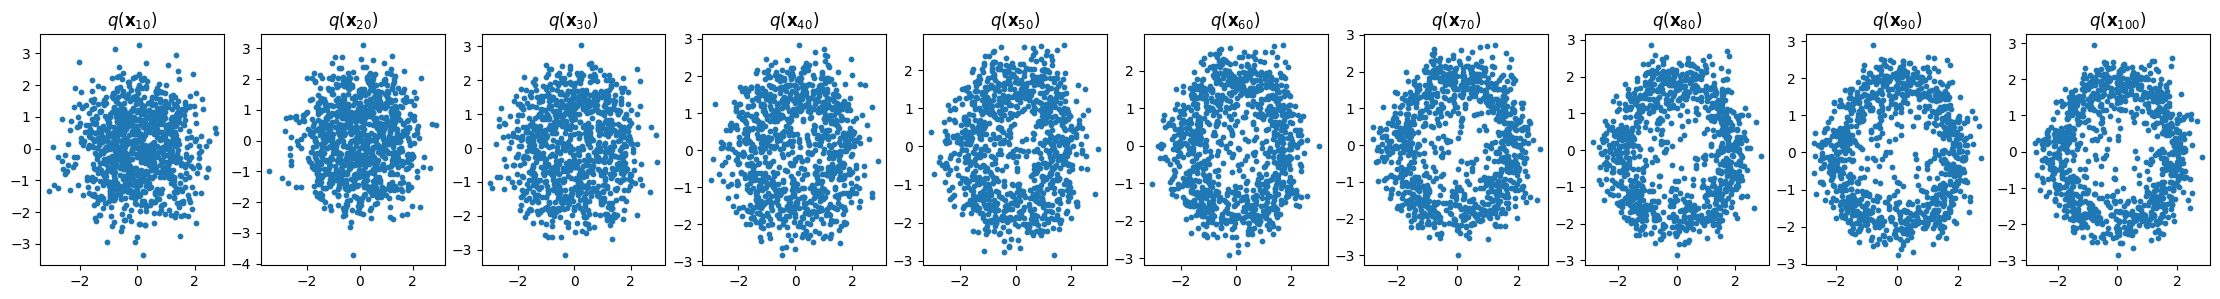

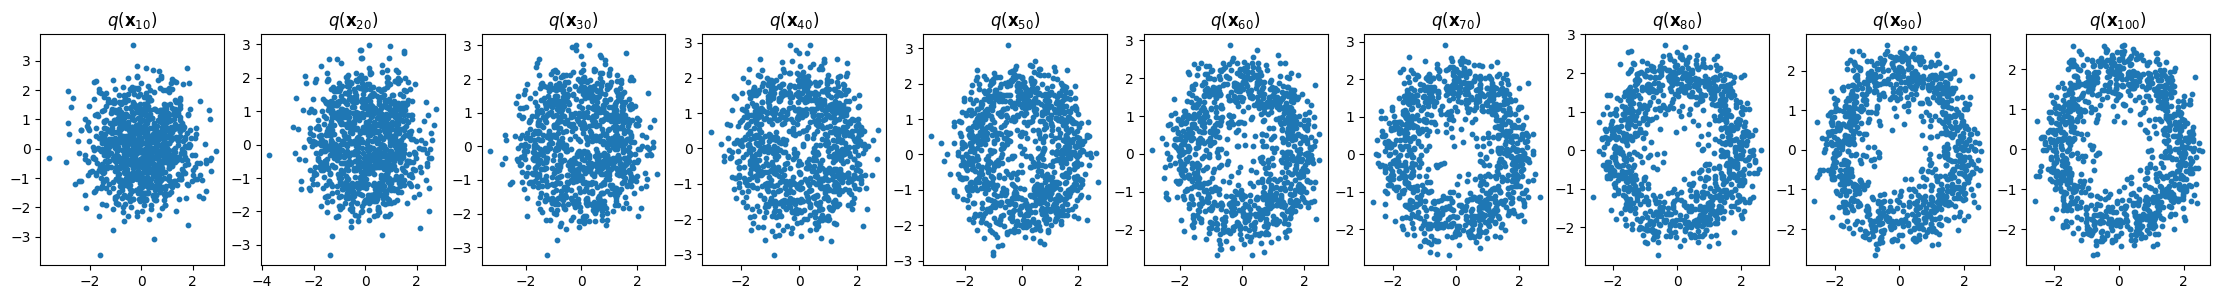

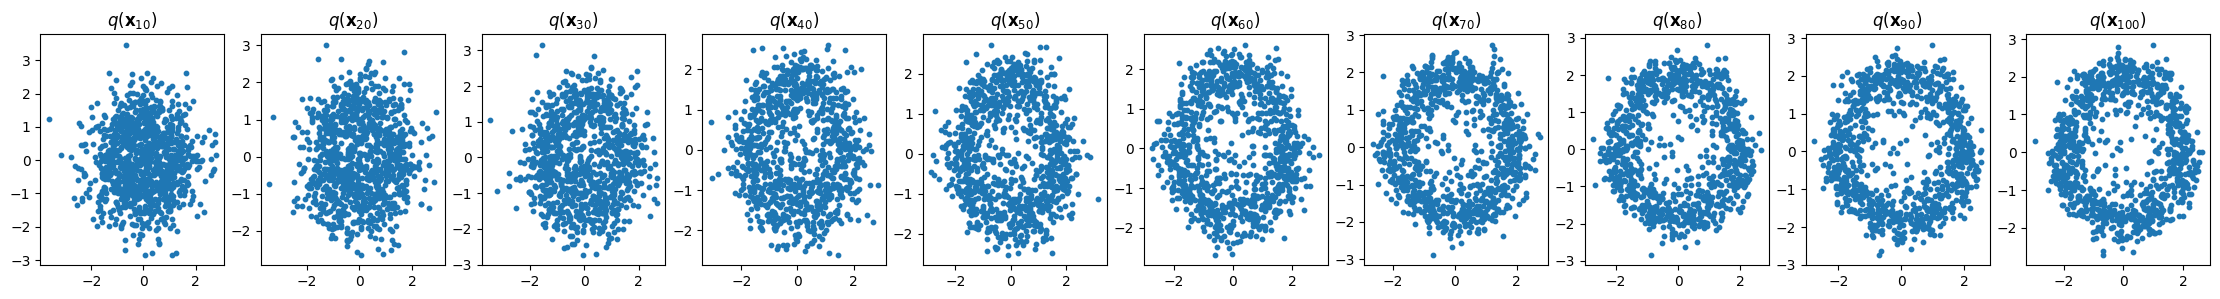

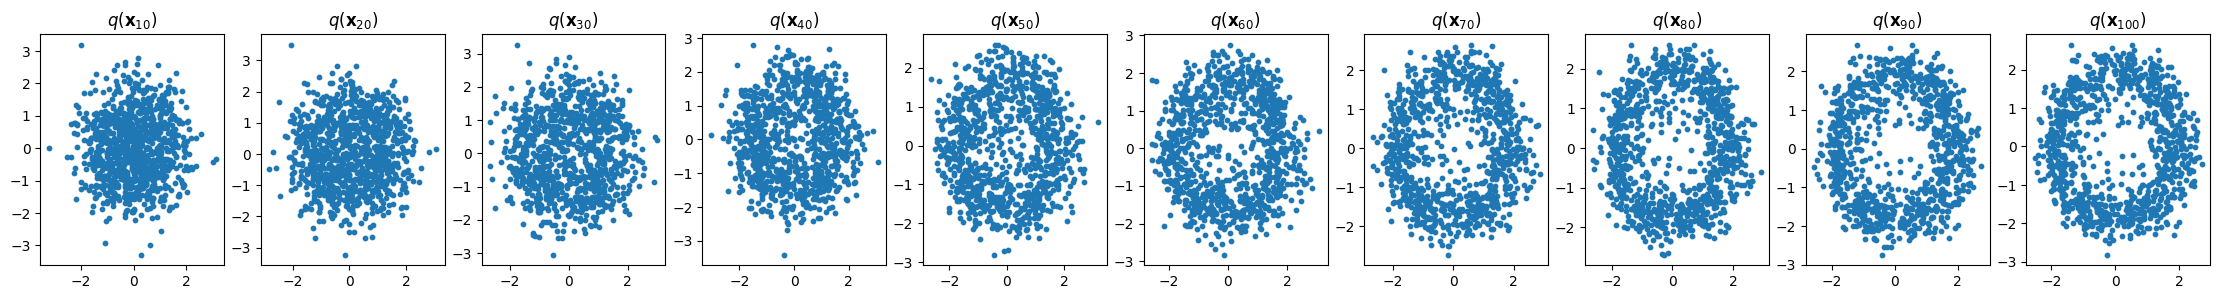

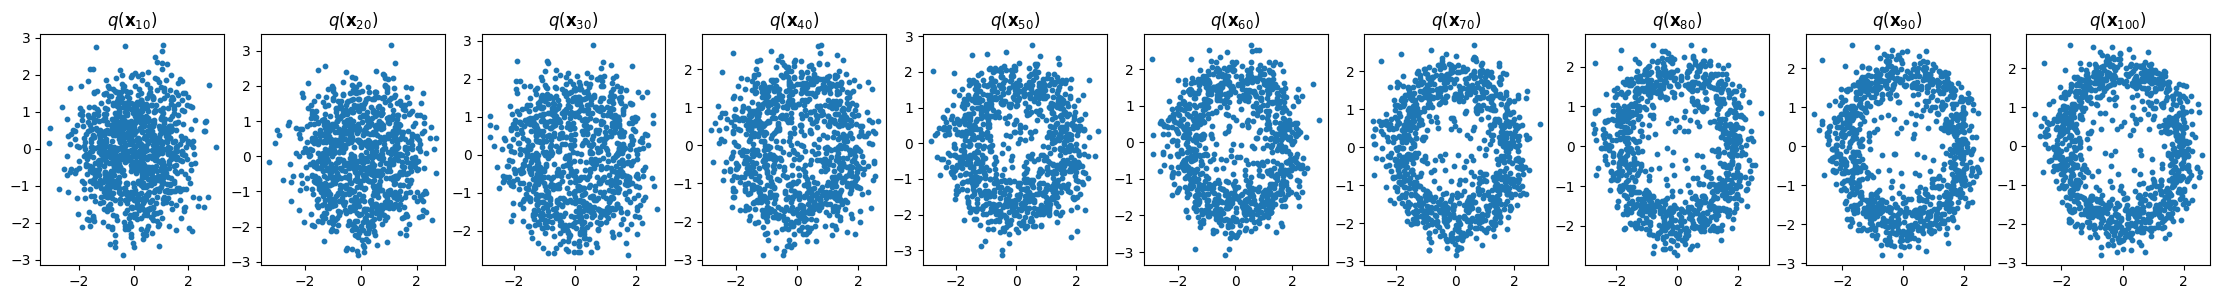

In [12]:
model = ConditionalModel(n_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataset = data
# Create EMA model
#ema = EMA(0.9)
#ema.register(model)
# Batch size
batch_size = 128
for t in range(2001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        #ema.update(model)
    # Print loss
    if (t % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [9]:
import torch
import torch.nn as nn
import math
import numpy as np
from utils import get_beta_schedule
from torch.nn.modules.loss import _Loss as tLoss
from torch.optim import Optimizer
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt


class Diffusion:
    def __init__(self, data: torch.tensor, num_diffusion_timesteps: int,
                 beta_start: int, beta_end: int, schedule: str,
                 model: nn.Module, loss_fn: tLoss,
                 optimizer: Optimizer):
        self.data = data
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.T = num_diffusion_timesteps
        betas = get_beta_schedule(schedule, beta_start=beta_start, beta_end=beta_end,
                                  num_diffusion_timesteps=num_diffusion_timesteps)
        self.alphas = 1-torch.tensor(betas, dtype=torch.float)
        self.alpha_bar = torch.cumprod(self.alphas, 0)
        
    def train(self, batch_size: int, epochs: int, plot_loss: bool = True):
        # TODO: Test
        # TODO: Add in TQDM progress bar and loss outputs
        n = len(self.data)
        d = self.data.shape[1]
        batch_in_epoch = math.ceil(n/batch_size)
        if plot_loss:
            losses = []
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            possible_indx = torch.tensor(range(0,n), dtype=torch.float)
            for batch in range(batch_in_epoch):
                # Batch Sample
                sample_size = min(batch_size, len(possible_indx))
                x0_ind = torch.multinomial(possible_indx, sample_size)
                # Updating Possible Index Choices After Sampling Without Replacement
                possible_indx = torch.tensor([i for i in possible_indx if i not in x0_ind])
                x0 = self.data[x0_ind]
                # Training Loss Calculations
                # Select a random step for each example
                t = torch.randint(0, self.T, size=(sample_size // 2 + 1,))
                t = torch.cat([t, self.T - t - 1], dim=0)[:batch_size].long()
                # model input
                #e = torch.randn_like(x0)
                e = MultivariateNormal(torch.tensor(np.zeros(d), dtype=torch.float), torch.eye(d)).rsample(torch.Size([sample_size]))
                x = x0 * torch.sqrt(self.alpha_bar[t]).reshape((-1,1)) + e * torch.sqrt(1 - self.alpha_bar[t]).reshape((-1,1))
                output = self.model(x.type(dtype=torch.float), t)
                loss = self.loss_fn(output, e)
                if plot_loss:
                    losses.append(loss.detach().numpy())
                # Backwards Step
                loss.backward()
                self.optimizer.step()
        if plot_loss:
            x_ax = range(0, len(losses))
            plt.plot(x_ax, losses)
            plt.xlabel('Batch Iteration')
            plt.ylabel('Batch Loss')
            plt.show()

    def forward(self, t, plot=True, **kwargs):
        """
        :param t:
        :type t:
        :param plot:
        :type plot:
        :param kwargs:
        :type kwargs:
        :return:
        :rtype:
        """
        d = self.data.shape[1]
        if plot:
            assert d == 2, 'Data is not 2d, cannot plot'
        alpha_bar = self.alpha_bar[t]
        cov = (1-alpha_bar)
        samples = []
        for i in range(d):
            d_data = self.data[:, i]
            mu_t = d_data*torch.sqrt(alpha_bar)
            samples.append(torch.normal(mu_t, cov))
        data_t = torch.stack(samples, dim=1)
        if plot:
            plt.scatter(data_t[:, 0], data_t[:, 1], **kwargs)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f'Samples At Time {t}')
        return data_t
    def sample(self, n, plot_intervals=None, sigma_mixture=0, **kwargs):
        cur_x = torch.randn((n, self.data.shape[1]))
        x_seq = [cur_x]
        for i in reversed(range(self.T)):
            t = torch.tensor([i])
            # Factor to the model output
            eps_factor = (1 - self.alphas[t].reshape((-1,1))) / torch.sqrt(1 - self.alpha_bar[t].reshape((-1,1)))
            # Model output
            eps_theta = model(cur_x, t)
            # Final values
            mean = (1 / torch.sqrt(self.alphas[t].reshape((-1,1)))) * (cur_x - (eps_factor * eps_theta))
            # Generate z
            z = torch.randn_like(cur_x)
            # Fixed sigma
            sigma_t = torch.sqrt(1-self.alphas[t].reshape(-1,1))
            cur_x = mean + sigma_t * z
            x_seq.append(cur_x)
            if plot_intervals:
                assert plot_intervals > 0, 'Plot Intervals Must Be Greater Than 0'
                assert cur_x.shape[1] == 2, 'Data is not 2d, cannot plot'
                if (i % plot_intervals) == 0:
                    plt.scatter(cur_x[:, 0].detach().numpy(), cur_x[:, 1].detach().numpy(), **kwargs)
                    plt.xlabel('X')
                    plt.ylabel('Y')
                    plt.title(f'Samples At Time {i}')
                    plt.show()
        return x_seq


In [10]:
n_steps=200
model = ConditionalModel(n_steps)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
diffusion = Diffusion(data, n_steps,
                 1e-5, 1e-2, 'linear',
                 model, loss, optimizer)

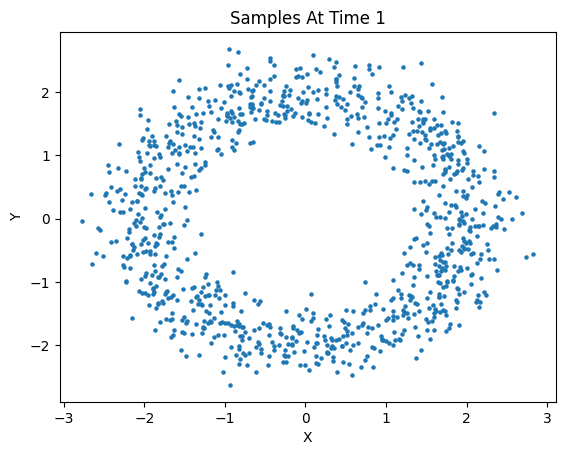

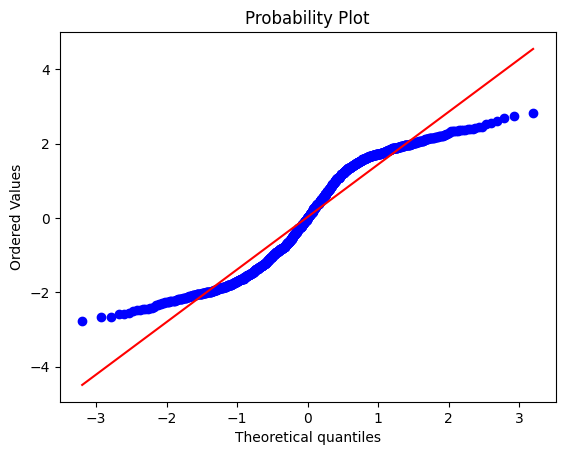

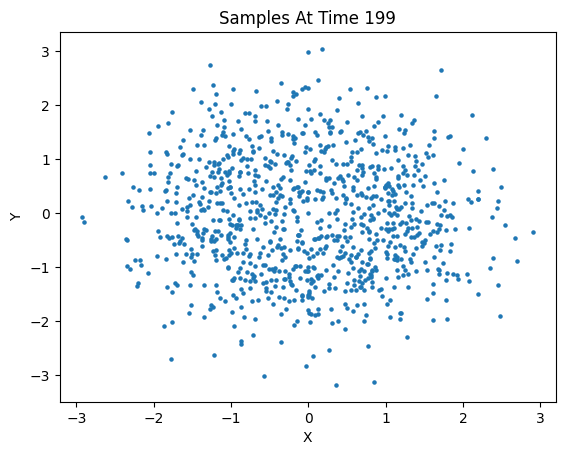

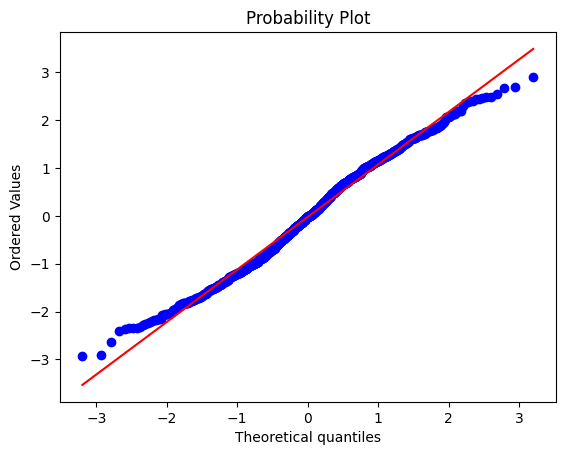

In [11]:
noised = diffusion.forward(1, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()
noised = diffusion.forward(199, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()

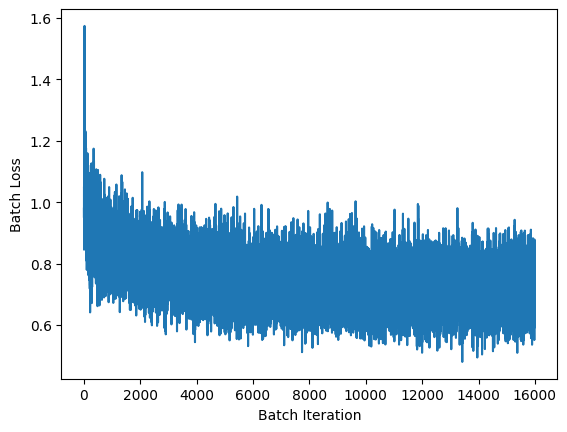

In [12]:
diffusion.train(128, 2000)

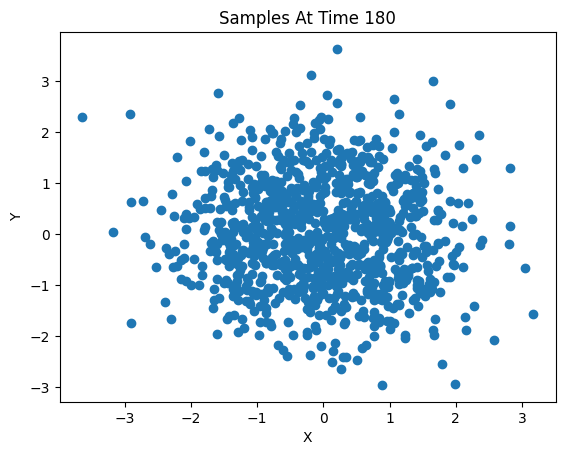

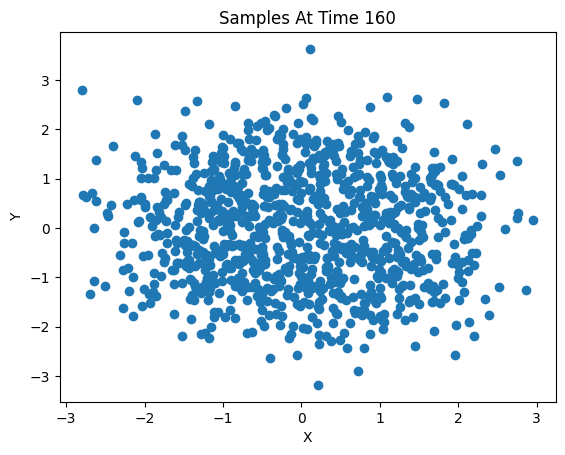

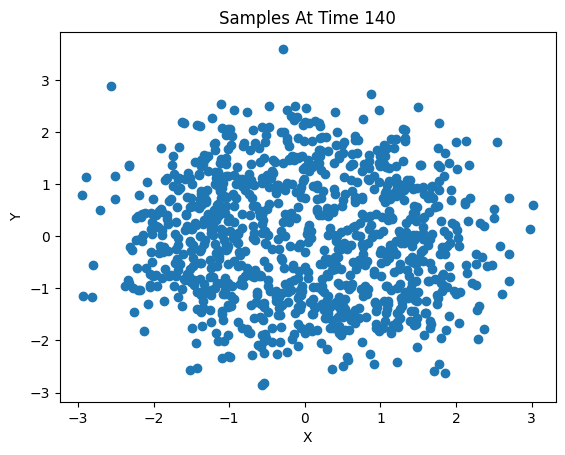

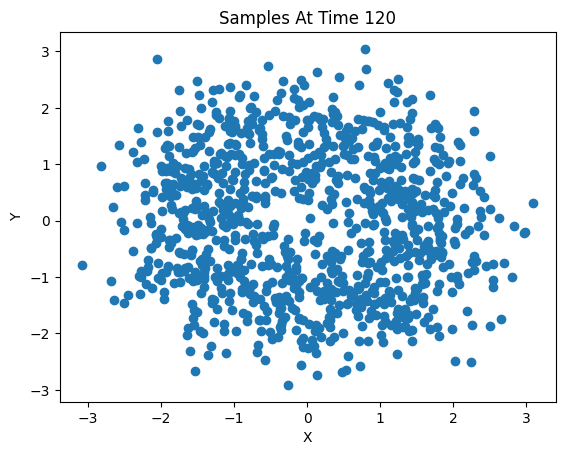

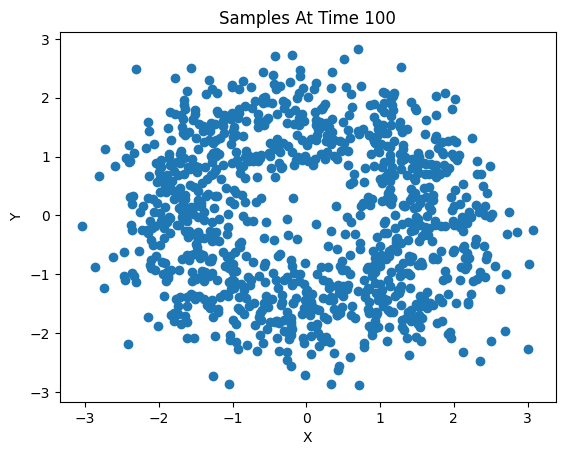

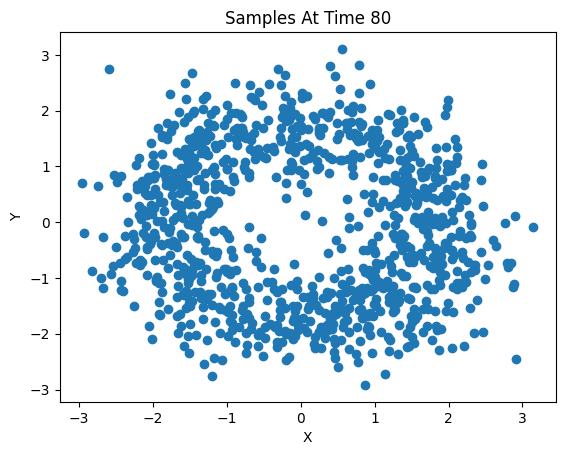

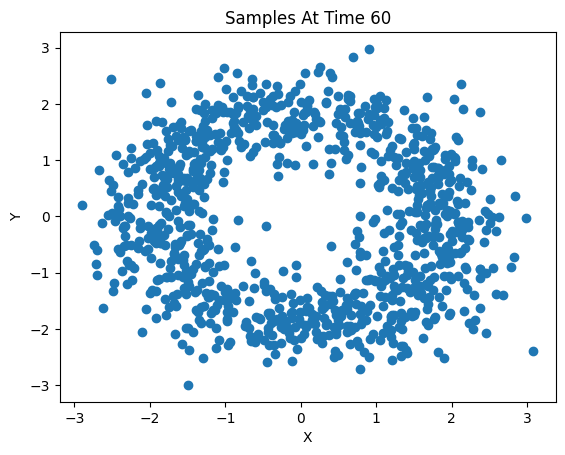

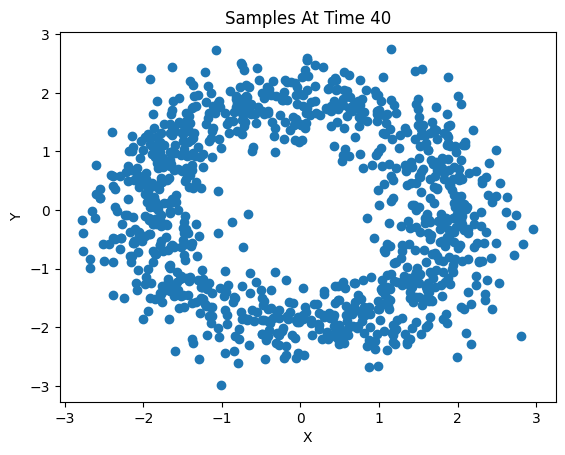

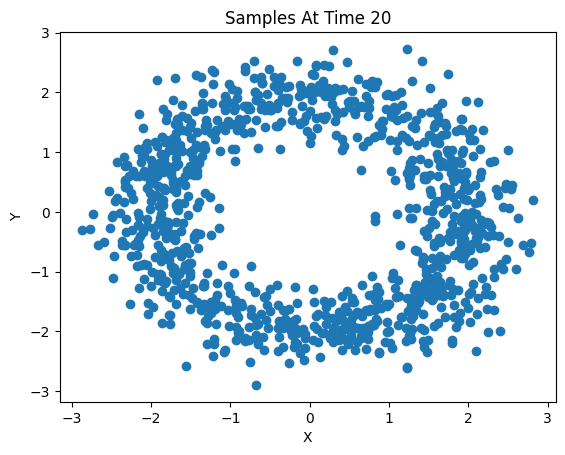

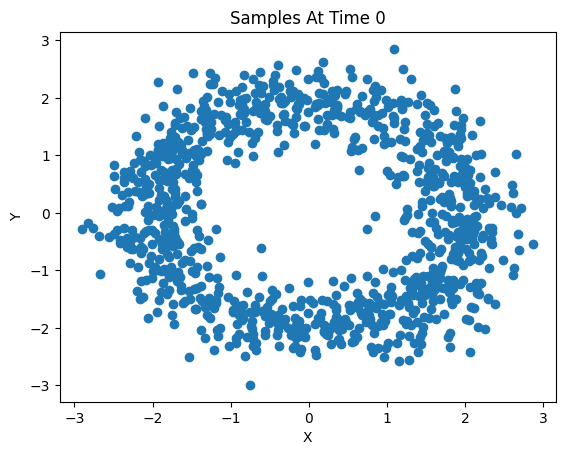

In [91]:
new_x = diffusion.sample(1000, 20)